In [1]:
import argparse
import numpy as np

def generate_evrp_data(
    dataset_size,
    evrp_size,
    cargo_capacity,
    battery_capacity,
    charging_station_prob=0.1  # Probability of a node being a charging station
):
    # Depot location (x, y)
    depots = np.random.uniform(size=(dataset_size, 2)).tolist()

    # Node locations (x, y)
    nodes = np.random.uniform(size=(dataset_size, evrp_size, 2)).tolist()

    # Node demands (1-9)
    demands = np.random.randint(1, 10, size=(dataset_size, evrp_size)).tolist()

    # Cargo capacity (constant per dataset)
    cargo_capacities = np.full(dataset_size, cargo_capacity).tolist()

    # Battery capacity (constant per dataset)
    battery_capacities = np.full(dataset_size, battery_capacity).tolist()

    # Charging stations (1 = charging station, 0 = regular node)
    charging_stations = (
        np.random.rand(dataset_size, evrp_size) < charging_station_prob
    ).astype(int).tolist()

    return list(zip(
        depots,
        nodes,
        demands,
        cargo_capacities,
        battery_capacities,
        charging_stations
    ))

In [2]:
# Capacities for different graph sizes
CARGO_CAPACITIES = {20: 30, 50: 40, 100: 50}
BATTERY_CAPACITIES = {20: 100, 50: 150, 100: 200}

dataset_size = 10000
evrp_sizes = [20, 50, 100]

# Generate EVRP datasets
evrp_datasets = {}
for size in evrp_sizes:
    evrp_datasets[f'evrp{size}'] = generate_evrp_data(
        dataset_size=dataset_size,
        evrp_size=size,
        cargo_capacity=CARGO_CAPACITIES[size],
        battery_capacity=BATTERY_CAPACITIES[size],
        charging_station_prob=0.1  # 10% of nodes are charging stations
    )

In [3]:
import matplotlib.pyplot as plt

def plot_evrp_instance(instance, title="EVRP Instance"):
    depot, nodes, demands, cargo_cap, battery_cap, charging_stations = instance
    depot = np.array(depot)
    nodes = np.array(nodes)
    demands = np.array(demands)
    charging_stations = np.array(charging_stations)

    plt.figure(figsize=(10, 6))

    # Plot depot (red star)
    plt.scatter(depot[0], depot[1], c='red', marker='*', s=200, label='Depot')

    # Plot regular nodes (blue circles)
    regular_nodes = nodes[charging_stations == 0]
    regular_demands = demands[charging_stations == 0]
    plt.scatter(
        regular_nodes[:, 0], regular_nodes[:, 1],
        c=regular_demands, cmap='viridis', s=regular_demands*20,
        alpha=0.7, label='Nodes'
    )

    # Plot charging stations (green squares)
    charging_nodes = nodes[charging_stations == 1]
    plt.scatter(
        charging_nodes[:, 0], charging_nodes[:, 1],
        c='green', marker='s', s=100, label='Charging Stations'
    )

    # Add labels and legend
    plt.colorbar(label='Demand')
    plt.title(f"{title} (Cargo: {cargo_cap}, Battery: {battery_cap})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(False)
    plt.show()

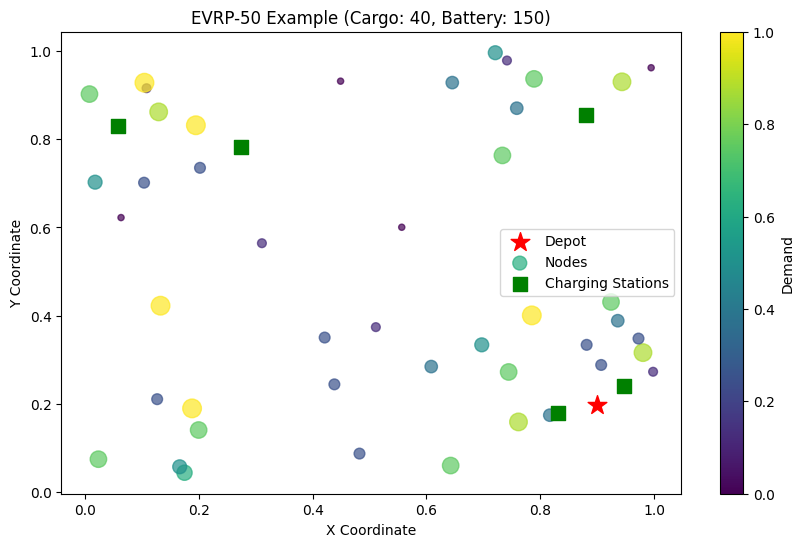

In [4]:
# Plot the first instance of the 50-node EVRP dataset
evrp50_dataset = evrp_datasets['evrp50']
plot_evrp_instance(evrp50_dataset[0], title="EVRP-50 Example")

In [5]:
import torch
import numpy as np
from torch import nn
import math


class SkipConnection(nn.Module):

    def __init__(self, module):
        super(SkipConnection, self).__init__()
        self.module = module

    def forward(self, input):
        return input + self.module(input)


class MultiHeadAttention(nn.Module):
    def __init__(
            self,
            n_heads,
            input_dim,
            embed_dim,
            val_dim=None,
            key_dim=None
    ):
        super(MultiHeadAttention, self).__init__()

        if val_dim is None:
            val_dim = embed_dim // n_heads
        if key_dim is None:
            key_dim = val_dim

        self.n_heads = n_heads
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.val_dim = val_dim
        self.key_dim = key_dim

        self.norm_factor = 1 / math.sqrt(key_dim)  # See Attention is all you need

        self.W_query = nn.Parameter(torch.Tensor(n_heads, input_dim, key_dim))
        self.W_key = nn.Parameter(torch.Tensor(n_heads, input_dim, key_dim))
        self.W_val = nn.Parameter(torch.Tensor(n_heads, input_dim, val_dim))

        self.W_out = nn.Parameter(torch.Tensor(n_heads, val_dim, embed_dim))

        self.init_parameters()

    def init_parameters(self):

        for param in self.parameters():
            stdv = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-stdv, stdv)

    def forward(self, q, h=None, mask=None):
        """

        :param q: queries (batch_size, n_query, input_dim)
        :param h: data (batch_size, graph_size, input_dim)
        :param mask: mask (batch_size, n_query, graph_size) or viewable as that (i.e. can be 2 dim if n_query == 1)
        Mask should contain 1 if attention is not possible (i.e. mask is negative adjacency)
        :return:
        """
        if h is None:
            h = q  # compute self-attention

        # h should be (batch_size, graph_size, input_dim)
        batch_size, graph_size, input_dim = h.size()
        n_query = q.size(1)
        assert q.size(0) == batch_size
        assert q.size(2) == input_dim
        assert input_dim == self.input_dim, "Wrong embedding dimension of input"

        hflat = h.contiguous().view(-1, input_dim)
        qflat = q.contiguous().view(-1, input_dim)

        # last dimension can be different for keys and values
        shp = (self.n_heads, batch_size, graph_size, -1)
        shp_q = (self.n_heads, batch_size, n_query, -1)

        # Calculate queries, (n_heads, n_query, graph_size, key/val_size)
        Q = torch.matmul(qflat, self.W_query).view(shp_q)
        # Calculate keys and values (n_heads, batch_size, graph_size, key/val_size)
        K = torch.matmul(hflat, self.W_key).view(shp)
        V = torch.matmul(hflat, self.W_val).view(shp)

        # Calculate compatibility (n_heads, batch_size, n_query, graph_size)
        compatibility = self.norm_factor * torch.matmul(Q, K.transpose(2, 3))
                # Apply mask
        if mask is not None:
            # Reshape mask to (batch_size, n_query, graph_size)
            mask = mask.unsqueeze(1)  # Add n_query dimension
            mask = mask.expand(-1, self.n_heads, -1, -1)  # (batch_size, n_heads, n_query, graph_size)
            mask = mask.permute(1, 0, 2, 3)  # (n_heads, batch_size, n_query, graph_size)
            compatibility[mask] = -np.inf

        # Optionally apply mask to prevent attention
        if mask is not None:
            mask = mask.unsqueeze(1)  # Add n_query dimension
            mask = mask.expand(-1, self.n_heads, -1, -1)  # (batch_size, n_heads, n_query, graph_size)
            mask = mask.permute(1, 0, 2, 3)  # (n_heads, batch_size, n_query, graph_size)
            compatibility[mask] = -np.inf
        attn = torch.softmax(compatibility, dim=-1)

        # If there are nodes with no neighbours then softmax returns nan so we fix them to 0
        if mask is not None:
            attnc = attn.clone()
            attnc[mask] = 0
            attn = attnc

        heads = torch.matmul(attn, V)

        out = torch.mm(
            heads.permute(1, 2, 0, 3).contiguous().view(-1, self.n_heads * self.val_dim),
            self.W_out.view(-1, self.embed_dim)
        ).view(batch_size, n_query, self.embed_dim)

        # Alternative:
        # headst = heads.transpose(0, 1)  # swap the dimensions for batch and heads to align it for the matmul
        # # proj_h = torch.einsum('bhni,hij->bhnj', headst, self.W_out)
        # projected_heads = torch.matmul(headst, self.W_out)
        # out = torch.sum(projected_heads, dim=1)  # sum across heads

        # Or:
        # out = torch.einsum('hbni,hij->bnj', heads, self.W_out)

        return out


class Normalization(nn.Module):

    def __init__(self, embed_dim, normalization='batch'):
        super(Normalization, self).__init__()

        normalizer_class = {
            'batch': nn.BatchNorm1d,
            'instance': nn.InstanceNorm1d
        }.get(normalization, None)

        self.normalizer = normalizer_class(embed_dim, affine=True)

        # Normalization by default initializes affine parameters with bias 0 and weight unif(0,1) which is too large!
        # self.init_parameters()

    def init_parameters(self):

        for name, param in self.named_parameters():
            stdv = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-stdv, stdv)

    def forward(self, input):

        if isinstance(self.normalizer, nn.BatchNorm1d):
            return self.normalizer(input.view(-1, input.size(-1))).view(*input.size())
        elif isinstance(self.normalizer, nn.InstanceNorm1d):
            return self.normalizer(input.permute(0, 2, 1)).permute(0, 2, 1)
        else:
            assert self.normalizer is None, "Unknown normalizer type"
            return input


class MultiHeadAttentionLayer(nn.Sequential):

    def __init__(
            self,
            n_heads,
            embed_dim,
            feed_forward_hidden=512,
            normalization='batch',
    ):
        super(MultiHeadAttentionLayer, self).__init__(
            SkipConnection(
                MultiHeadAttention(
                    n_heads,
                    input_dim=embed_dim,
                    embed_dim=embed_dim
                )
            ),
            Normalization(embed_dim, normalization),
            SkipConnection(
                nn.Sequential(
                    nn.Linear(embed_dim, feed_forward_hidden),
                    nn.ReLU(),
                    nn.Linear(feed_forward_hidden, embed_dim)
                ) if feed_forward_hidden > 0 else nn.Linear(embed_dim, embed_dim)
            ),
            Normalization(embed_dim, normalization)
        )


class GraphAttentionEncoder(nn.Module):
    def __init__(
            self,
            n_heads,
            embed_dim,
            n_layers,
            node_dim=None,
            normalization='batch',
            feed_forward_hidden=512
    ):
        super(GraphAttentionEncoder, self).__init__()

        # To map input to embedding space
        self.init_embed = nn.Linear(node_dim, embed_dim) if node_dim is not None else None

        self.layers = nn.Sequential(*(
            MultiHeadAttentionLayer(n_heads, embed_dim, feed_forward_hidden, normalization)
            for _ in range(n_layers)
        ))

    def forward(self, x, mask=None):

        assert mask is None, "TODO mask not yet supported!"

        # Batch multiply to get initial embeddings of nodes
        h = self.init_embed(x.view(-1, x.size(-1))).view(*x.size()[:2], -1) if self.init_embed is not None else x

        h = self.layers(h)

        return (
            h,  # (batch_size, graph_size, embed_dim)
            h.mean(dim=1),  # average to get embedding of graph, (batch_size, embed_dim)
        )

In [6]:
class EVRPGraphAttentionEncoder(GraphAttentionEncoder):
    def __init__(
            self,
            n_heads,
            embed_dim,
            n_layers,
            normalization='batch',
            feed_forward_hidden=512
    ):
        # Node features: x, y, demand, is_charging, is_depot, cargo_cap, battery_cap
        node_dim = 7
        super().__init__(
            n_heads=n_heads,
            embed_dim=embed_dim,
            n_layers=n_layers,
            node_dim=node_dim,  # Updated to include EVRP features
            normalization=normalization,
            feed_forward_hidden=feed_forward_hidden
        )

In [7]:
def preprocess_evrp_instance(instance):
    depot, nodes, demands, cargo_cap, battery_cap, charging_stations = instance

    # Convert to numpy arrays
    depot = np.array(depot)
    nodes = np.array(nodes)
    demands = np.array(demands)
    charging_stations = np.array(charging_stations)

    # Create node features matrix
    num_nodes = 1 + len(nodes)  # Depot + customer/charging nodes
    node_features = np.zeros((num_nodes, 7))  # (graph_size, 7)

    # Depot features: [x, y, demand=0, is_charging=0, is_depot=1, cargo_cap, battery_cap]
    node_features[0] = [
        depot[0], depot[1], 0, 0, 1, cargo_cap, battery_cap
    ]

    # Customer/charging node features
    for i in range(len(nodes)):
        node_features[i + 1] = [
            nodes[i][0], nodes[i][1],       # x, y
            demands[i],                     # demand
            charging_stations[i],           # is_charging (0/1)
            0,                              # is_depot (0)
            cargo_cap, battery_cap          # global capacities
        ]

    return torch.FloatTensor(node_features)

# Batch preprocessing
def preprocess_evrp_batch(batch):
    return torch.stack([preprocess_evrp_instance(inst) for inst in batch])

In [8]:
# Initialize encoder
encoder = EVRPGraphAttentionEncoder(
    n_heads=8,
    embed_dim=128,
    n_layers=3
)

# Preprocess a batch of EVRP instances
batch = evrp_datasets['evrp20'][:32]  # Batch of 32 instances
preprocessed_batch = preprocess_evrp_batch(batch)  # Shape: (32, graph_size, 7)

# Forward pass
embeddings, graph_embedding = encoder(preprocessed_batch)
print("Node embeddings shape:", embeddings.shape)  # (32, graph_size, 128)

Node embeddings shape: torch.Size([32, 21, 128])


In [ ]:
#import torch.functional as F
#def compute_reward(route, battery_used, cargo_used):
    # Penalize battery/capacity overflows
    #battery_penalty = torch.sum(F.relu(battery_used - battery_capacity))
    #cargo_penalty = torch.sum(F.relu(cargo_used - cargo_capacity))
    # Reward valid routes
    #return - (battery_penalty + cargo_penalty)

In [ ]:
assert preprocessed_batch.size(-1) == 7, "Node features must have dim 7"

In [ ]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

class EVRPAttentionDecoder(nn.Module):
    def __init__(self, embed_dim, n_heads=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.project_context = nn.Linear(embed_dim + 2, embed_dim)  # +2 for battery/cargo
        self.node_attention = MultiHeadAttention(n_heads, embed_dim, embed_dim)
        self.logit = nn.Linear(embed_dim, 1)

    def forward(self, encoder_embeddings, battery_remaining, cargo_remaining,
                mask=None, current_node=None, instances=None):
        batch_size, graph_size, _ = encoder_embeddings.size()

        # Create context vector
        if current_node is None:  # Initial step
            context = torch.cat([encoder_embeddings[:, 0],
                               cargo_remaining,
                               battery_remaining], dim=1)
        else:
            context = torch.cat([encoder_embeddings[torch.arange(batch_size), current_node],
                               cargo_remaining,
                               battery_remaining], dim=1)

        context = self.project_context(context)
        query = context.unsqueeze(1).expand(-1, graph_size, -1)

        # Compute compatibility
        compatibility = self.node_attention(query, encoder_embeddings, mask=mask)
        logits = self.logit(compatibility).squeeze(-1)

        # Apply masking
        if mask is not None:
            logits[mask] = -np.inf

         # Generate transient masks
        transient_mask = torch.zeros_like(logits, dtype=torch.bool)
        for i in range(batch_size):
        # ... (existing transient masking logic)

        # Combine permanent and transient masks
          final_mask = visited_mask.bool() | transient_mask

           # Reshape mask for multi-head attention
          final_mask = final_mask.unsqueeze(1)  # (batch_size, 1, graph_size)
          final_mask = final_mask.expand(-1, self.node_attention.n_heads, -1, -1)
        return logits, final_mask



def train_step(batch):
    # Preprocess batch
    preprocessed = preprocess_evrp_batch(batch)
    batch_size = preprocessed.size(0)

    # Initialize states
    battery = torch.tensor([[inst[4]] for inst in batch]).float()  # Full battery
    cargo = torch.tensor([[inst[3]] for inst in batch]).float()    # Full cargo
    visited_mask = torch.zeros(batch_size, preprocessed.size(1), dtype=torch.bool)
    current_node = None

    # Forward encoder
    encoder_embeddings, _ = encoder(preprocessed)

    # Store trajectory
    log_probs = []
    rewards = []

    # Rollout
    for _ in range(100):  # Max steps
        logits = decoder(
            encoder_embeddings,
            battery_remaining=battery,
            cargo_remaining=cargo,
            mask=visited_mask,
            current_node=current_node,
            instances=batch
        )

        # Sample action
        prob = torch.softmax(logits, dim=-1)
        actions = torch.multinomial(prob, num_samples=1).squeeze(1)
        log_prob = torch.log(prob.gather(-1, actions.unsqueeze(-1))).squeeze()

        # Update state
        new_battery, new_cargo = update_state(battery, cargo, current_node, actions, batch)
        visited_mask[torch.arange(batch_size), actions] = True

        # Compute reward
        step_reward = compute_step_reward(actions, new_battery, new_cargo, batch)

        # Store trajectory
        log_probs.append(log_prob)
        rewards.append(step_reward)

        # Update for next step
        battery, cargo = new_battery, new_cargo
        current_node = actions

        # Break if all returned to depot
        if (actions == 0).all():
            break

    # Calculate loss
    log_probs = torch.stack(log_probs)
    rewards = torch.stack(rewards)

    # Discount rewards
    discounted_rewards = []
    R = 0
    for r in reversed(rewards):
        R = r + 0.99 * R  # γ=0.99
        discounted_rewards.insert(0, R)
    discounted_rewards = torch.stack(discounted_rewards)

    # Normalize rewards
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

    # REINFORCE loss
    loss = -torch.mean(log_probs * discounted_rewards)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
    optimizer.step()

    return loss.item(), torch.mean(torch.stack(rewards)).item()

# Helper functions
def update_state(prev_battery, prev_cargo, current_node, next_node, batch):
    new_battery = prev_battery.clone()
    new_cargo = prev_cargo.clone()

    for i in range(len(batch)):
        instance = batch[i]
        depot = np.array(instance[0])
        nodes = np.array(instance[1])
        demands = instance[2]
        charging = instance[5]

        if current_node is None or current_node[i] is None:
            current_pos = depot
        else:
            current_pos = nodes[current_node[i]-1] if current_node[i] > 0 else depot

        next_pos = depot if next_node[i] == 0 else nodes[next_node[i]-1]

        # Update battery
        distance = np.linalg.norm(current_pos - next_pos)
        new_battery[i] -= distance

        # Charging station reset
        if next_node[i] != 0 and charging[next_node[i]-1]:
            new_battery[i] = instance[4]  # Full charge

        # Update cargo
        if next_node[i] != 0:  # Not depot
            new_cargo[i] -= demands[next_node[i]-1]

    return new_battery.clamp(min=0), new_cargo.clamp(min=0)

def compute_step_reward(actions, battery, cargo, batch):
    rewards = torch.zeros(len(batch))
    for i in range(len(batch)):
        # Penalize constraints
        if battery[i] < 0:
            rewards[i] -= 100
        if cargo[i] < 0:
            rewards[i] -= 100

        # Reward depot return with empty cargo
        if actions[i] == 0 and cargo[i] <= 1e-3:
            rewards[i] += 50

    return rewards

# Initialize components
encoder = EVRPGraphAttentionEncoder(n_heads=8, embed_dim=128, n_layers=3)
decoder = EVRPAttentionDecoder(embed_dim=128)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
# Training loop
# Training parameters
n_epochs = 1
batch_size = 32
dataset = evrp_datasets['evrp20']

for epoch in range(n_epochs):
    epoch_loss = 0
    epoch_reward = 0

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        loss, reward = train_step(batch)
        epoch_loss += loss
        epoch_reward += reward

    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {epoch_loss:.2f} | Avg Reward: {epoch_reward:.2f}")

RuntimeError: The expanded size of the tensor (8) must match the existing size (32) at non-singleton dimension 1.  Target sizes: [-1, 8, -1, -1].  Tensor sizes: [32, 1, 21]